Example of using the RandomRotDitherPerFilterChange stacker. 
This adds a random offset to all rotTelPos values after a filter change. 

In [1]:
from __future__ import print_function
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from collections import OrderedDict

In [2]:
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as mafUtils
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles

In [3]:
dataDir = '.'
runName = 'astro-lsst-01_2022'
dbfile = os.path.join(dataDir, runName + '.db')
print(dbfile)
opsdb = db.OpsimDatabase(dbfile)

./astro-lsst-01_2022.db


Test the new stacker. 

In [4]:
# We'll run two metrics connected with angles - one on the original rotTelPos and one on the dithered rotTelPos.
rms_orig = metrics.RmsAngleMetric(col='rotTelPos')
mean_orig = metrics.MeanAngleMetric(col='rotTelPos')
rms_dith = metrics.RmsAngleMetric(col='randomDitherPerFilterChangeRotTelPos')
mean_dith = metrics.MeanAngleMetric(col='randomDitherPerFilterChangeRotTelPos')
slicer = slicers.HealpixSlicer(latLonDeg=True)  
sqlconstraint= 'night < 365'
stacker = stackers.RandomRotDitherPerFilterChangeStacker(degrees=True, randomSeed=42)
plotFuncs = [plots.HealpixSkyMap()]

bundles = {}
bundles['rms_orig'] = metricBundles.MetricBundle(rms_orig, slicer, constraint=sqlconstraint, stackerList=[], 
                                                 plotFuncs=plotFuncs)
bundles['mean_orig'] = metricBundles.MetricBundle(mean_orig, slicer, constraint=sqlconstraint, stackerList=[], 
                                                  plotFuncs=plotFuncs)
bundles['rms_dith'] = metricBundles.MetricBundle(rms_dith, slicer, constraint=sqlconstraint, stackerList=[stacker], 
                                                 plotFuncs=plotFuncs)
bundles['mean_dith'] = metricBundles.MetricBundle(mean_dith, slicer, constraint=sqlconstraint, stackerList=[stacker], 
                                                  plotFuncs=plotFuncs)

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


In [5]:
outDir = os.path.join(dataDir, 'stacker_test')
resultsDb = db.ResultsDb(outDir=outDir)

bgroup = metricBundles.MetricBundleGroup(bundles, opsdb, outDir=outDir, resultsDb=resultsDb)
# run the bundle
bgroup.runAll()

Querying database SummaryAllProps with constraint night < 365 for columns ['fieldRA', 'fieldDec', 'filter', 'rotTelPos']
Found 227468 visits
Running:  ['rms_orig', 'mean_orig', 'rms_dith', 'mean_dith']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [6]:
# Let's just check in on the data that was included in the metrics.
print(bgroup.simData.dtype.names)

('fieldRA', 'fieldDec', 'filter', 'rotTelPos', 'randomDitherPerFilterChangeRotTelPos')


Great - the new column is added.

{'SkyMap': 2}

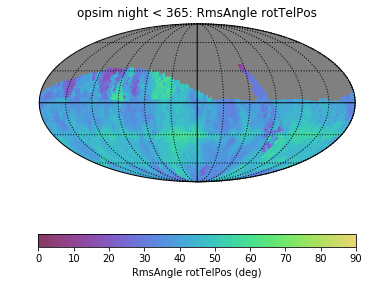

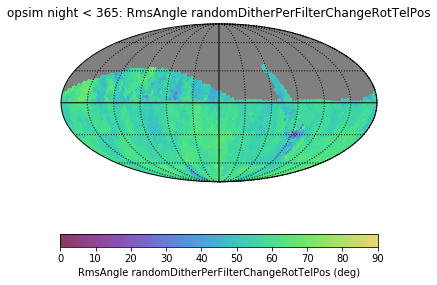

In [7]:
plotDict = {'colorMin': 0, 'colorMax': 90}
for b in ['rms_orig', 'rms_dith']:
    bundles[b].setPlotDict(plotDict)
bundles['rms_orig'].plot()
bundles['rms_dith'].plot()

{'SkyMap': 2}

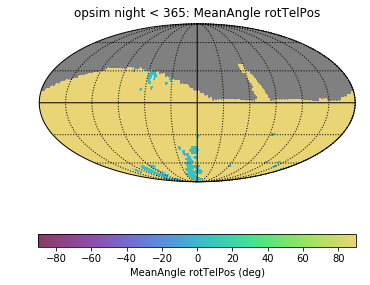

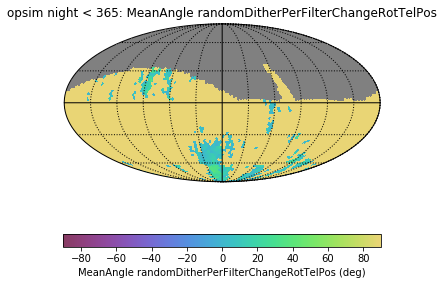

In [8]:
plotDict = {'colorMin': -90, 'colorMax': 90}
for b in ['mean_orig', 'mean_dith']:
    bundles[b].setPlotDict(plotDict)
bundles['mean_orig'].plot()
bundles['mean_dith'].plot()

I think this means that the distribution of angles is wider when you add this random rotation offset at each filter change, and because the distribution is wider, more places on the sky have a mean of 0. 

We can also check in on the dither offsets. 

In [9]:
offsets = bgroup.simData['randomDitherPerFilterChangeRotTelPos'] - bgroup.simData['rotTelPos']
filters = bgroup.simData['filter']

Text(0.5,0,'RotTelPos Offsets')

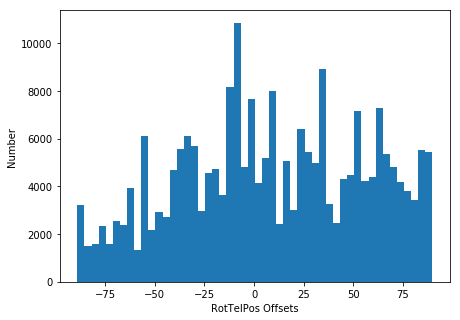

In [10]:
plt.figure(figsize=(7, 5))
plt.hist(offsets, bins=50)
plt.ylabel("Number")
plt.xlabel("RotTelPos Offsets")

In [11]:
eps = 1e-10
offsetchanges = np.where(np.abs(offsets[1:] - offsets[:-1]) > eps )[0]
for i in offsetchanges[0:10]:
    print(i, filters[i], filters[i+1])

164 z r
184 r g
194 g i
214 i z
240 z y
311 y r
331 r g
341 g i
342 i i
343 i i


We can see that most of the time, the offsets are changing at the same place the filter is changing, as intended.
The last couple of changes here occur because we cannot rotate the camera beyond its limits (-90, 90) and the offset has caused the dithered position to hit this limit. 

In [12]:
# Hitting the camera rotator limit.
print('As implemented dither offsets', offsets[340:345])
print('Original rotTelPos', bgroup.simData['rotTelPos'][340:345])
print('Dithered rotTelPos', bgroup.simData['randomDitherPerFilterChangeRotTelPos'][340:345])

As implemented dither offsets [-79.54494981 -79.54494981  42.31564338  40.49688866  40.07724635]
Original rotTelPos [ 46.82111807  47.25375162  47.68435662  49.50311134  49.92275365]
Dithered rotTelPos [-32.72383174 -32.29119819  90.          90.          90.        ]
